In [ ]:
!pip3 install torch
!pip3 install torchvision
!pip3 install torchaudio

# Part 1: A speech classification training loop, implementing a ConvNet, computing WER

This includes 4 exercises: sections 1.3, 1.4, 1.5, 1.6. This doc can be helpful https://pytorch.org/docs/stable/index.html

## 1.1 Loading the dataset

In [ ]:
import torchaudio
import torch
from torchaudio.datasets import YESNO, LIBRISPEECH
from torch.utils.data import DataLoader

In [ ]:
def collate_fn(batch):
  tensors = [b[0].t() for b in batch if b]
  tensors = torch.nn.utils.rnn.pad_sequence(tensors, batch_first=True)
  tensors = tensors.transpose(1, -1)

  targets = torch.tensor([b[2] for b in batch if b])
  targets = torch.nn.utils.rnn.pad_sequence(targets, batch_first=True)

  return tensors, targets

dataset = YESNO(".", download=True)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True,
                                          num_workers=2, collate_fn=collate_fn)

## 1.2 Features

We are using standard speech features, do not worry about it today, we will come back to it in section 2 of the lab.

In [ ]:
# Classic speech rec. features
melfbanks = torchaudio.transforms.MelSpectrogram(n_mels=80)

# The original/standard LibriSpeech SpecAugment policy:
# 80 Mel filters
# 2 frequency masks max 27 frequency bands out of 80
# 2 time masks max 100 timesteps (1 second)
# see https://arxiv.org/abs/1904.08779
timemasking = torchaudio.transforms.TimeMasking(100)
freqmasking = torchaudio.transforms.FrequencyMasking(27)

## 1.3 Model

**Exercise 1:** to start, we are working with the Yes/No dataset, that comprises always "yes" or "no" sequences of length exactly 8. Code a ConvNet based model which takes a variable length input, with 80 features (see above: 1.2 Features) and always output 8 (binary) values.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleConvNet(nn.Module):
  def __init__(self, kernel_size=3, stride=1, padding=1, depth=5):  ### Those are not good hyperparameters
    super(SimpleConvNet, self).__init__()
    self.conv_featuers = nn.Sequential(nn.Conv1d(in_channels = 80, out_channels = 248, kernel_size = 3, padding = 1, stride = 1),
                                       nn.BatchNorm1d(248), nn.ReLU(), nn.MaxPool1d(3),
                                       nn.Conv1d(in_channels = 248, out_channels = 128, kernel_size = 3, padding = 1, stride = 1), 
                                       nn.BatchNorm1d(128), nn.ReLU(), nn.MaxPool1d(3),
                                       nn.Conv1d(in_channels = 128, out_channels = 64, kernel_size = 3, padding = 1, stride = 1),
                                       nn.BatchNorm1d(64), nn.ReLU(), nn.MaxPool1d(3))
       
    self.averge_pool = nn.AdaptiveAvgPool1d(1)
    self.linear = nn.Linear(64, 8)

  def forward(self, x):
    x = x.squeeze(1)
    x = self.conv_featuers(x)
    x = self.averge_pool(x)
    x = x.view(x.size(0),-1)
    x = self.linear(x)
    return x 

model = SimpleConvNet()

## 1.4 Visualize features and network output

**Exercise 2:** visualize the input waveform, the MelSpectrogram features before and after data augmentation with SpecAugment, and the model's output (you could for instance use plt.plot, plt.imshow, plt.bar). Use this to debug your model's forward.

<class 'torch.Tensor'> torch.Size([16, 1, 55840])
<class 'torch.Tensor'> torch.Size([16, 8])


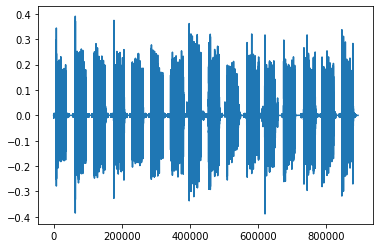

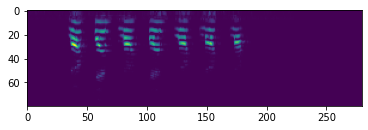

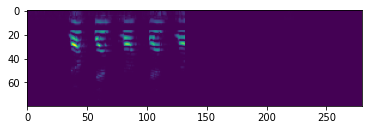

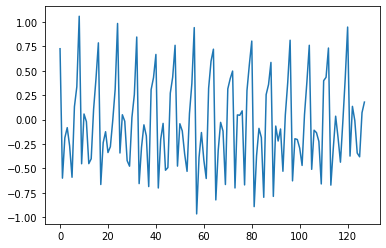

In [ ]:
from matplotlib import pyplot as plt
x, y = next(iter(data_loader))
print(type(x), x.shape)
print(type(y), y.shape)
plt.figure()
plt.plot(x.flatten(start_dim=0))
x = torch.log(1. + melfbanks(x))  # Those are the speech features we can train on
plt.figure()
### TODO: visualize input features
plt.imshow(x[0].squeeze(0))
x = timemasking(freqmasking(x))  # Those are the speech featues with some data augmentation (SpecAugment) applied, better to train on that to avoid overfitting
plt.figure()
plt.imshow(x[0].squeeze(0))
x = model.to("cpu")(x)
plt.figure()
#print(x.flatten(start_dim=1).shape)
plt.plot(x.flatten(start_dim=0).detach().numpy())
plt.show()

## 1.5 Training loop including loss and model updates

**Exercise 3:** implement a training loop with your previously defined model (fix it if necessary). Here we don't have a validation nor a test set, so the task is to overfit the train set (bring the training loss to almost 0). Then try SpecAugment.
Hint: I got it to work with BCE, MSE and MultiLabel losses. If you can't overfit the train set, change your model from 1.3.

BONUS: you can add other data augmentations from https://pytorch.org/audio/transforms.html

In [ ]:
import torch.optim as optim

N_EPOCHS = 100

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = SimpleConvNet().to(device) ### TODO hyperparams ###

criterion = nn.MSELoss()  ### TODO ###
optimizer = optim.AdamW(model.parameters(),lr = 0.001)  ### TODO ###

running_loss = 0.0
i = 0
for epoch in range(N_EPOCHS):
  for x, y in data_loader:
    ### TODO compute the speech features (example in 1.4) ###
    x = torch.log(1. + melfbanks(x)) 
    x = timemasking(freqmasking(x))
    x, y = x.to(device), y.to(device)
    ### TODO train the model ###
    pred = model(x)
    loss = criterion(pred,y.type_as(pred))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    i += 1
    running_loss += loss.item()
    if i % 20 == 0:
      print("loss: %.8f" % (running_loss / 20))
      running_loss = 0.0

loss: 0.34179012
loss: 0.19750170
loss: 0.16905294
loss: 0.15456278
loss: 0.13666283
loss: 0.12033820
loss: 0.10735562
loss: 0.08511579
loss: 0.06678973
loss: 0.07428351
loss: 0.07417333
loss: 0.07134270
loss: 0.05732050
loss: 0.04266927
loss: 0.05098235
loss: 0.04324582
loss: 0.05264783
loss: 0.04704755
loss: 0.04602324
loss: 0.04766171


## 1.6 Implementing WER

In [ ]:
!pip install jiwer

**Exercise 4:** implement WER and compare to jiwer.

In [ ]:
from jiwer import wer
import re
import numpy as np 
punctuation = re.compile('[,.?!:;"]')

ground_truth =  punctuation.sub("", "I like monthy python, and AMMI is awesome")
hypothesis =  punctuation.sub("", "I like python, what is AMMI? it is awesome")

def mywer(g, h):  # gold, hypothesis
  # dynamic programming algorithm that returns
  # (substitutions + deletions + insertions) / ground_truth_nb_words
  ### TODO initialize
  ### TODO compute the alignment
  #raise NotImplementedError
  g = g.split(" ")
  h = h.split(" ")
  d = np.zeros((len(g) + 1)* (len(h)+1),dtype=np.uint8)
  d = d.reshape((len(g) + 1 , len(h) + 1))
  for i in range(len(g) + 1):
    for j in range(len(h) + 1):
      if i == 0:
        d[0][j] = j
      elif j == 0:
        d[i][0] = i
  for i in range(1,len(g) + 1):
    for j in range(1,len(h) + 1):
      if g[i - 1] == h[j - 1]:
        d[i][j] = d[i - 1][j - 1]
      else:
        substitution = d[i - 1][j - 1] + 1
        insertion = d[i][j - 1] + 1
        deletion = d[i - 1][j] + 1
        d[i][j] = min(substitution,insertion,deletion)
  return float(d[len(g)][len(h)]) / len(g)

assert mywer(ground_truth, hypothesis) == wer(ground_truth, hypothesis)
print(mywer(ground_truth, hypothesis), wer(ground_truth, hypothesis))

0.5 0.5


# Part 2: implementing speech features

May be helpful:
https://pytorch.org/tutorials/beginner/audio_preprocessing_tutorial.html
and https://librosa.github.io/librosa/index.html and ![alt text](https://s3-eu-west-1.amazonaws.com/pfigshare-u-previews/1853261/preview.jpg)

## 2.1 spectrogram

In [ ]:
import IPython
IPython.display.Audio("waves_yesno/0_1_0_1_1_0_1_0.wav", rate=16000)

**Exercise 1:** using https://numpy.org/doc/stable/reference/generated/numpy.hanning.html and https://numpy.org/doc/stable/reference/generated/numpy.fft.fft.html compute the spectrogram of the waveform (short-time Fourier transforms) with window size 25ms and stride 10ms, and 256 frequencies. Plot and compare your spectrogram to `torchaudio.transforms.Spectrogram()` on one file from YESNO (see 1.4). **They will probably not match exactly in values** as it depends of a lot of pre- and post-processing of the signal, but what matters is that the plots look similar.

<class 'torch.Tensor'> torch.Size([16, 1, 54080])
<class 'torch.Tensor'> torch.Size([16, 8])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


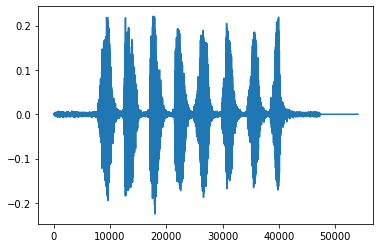

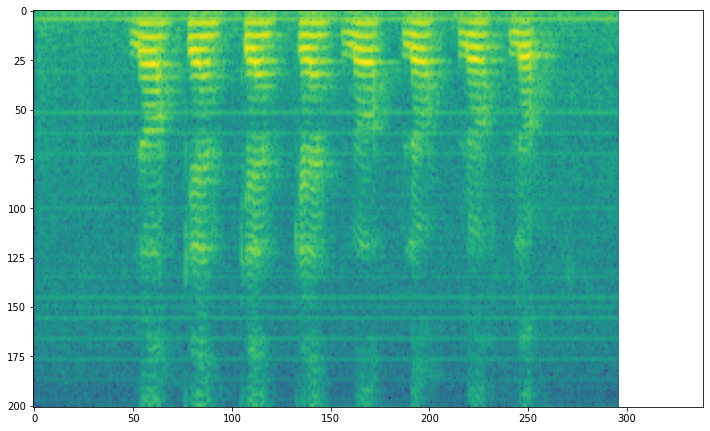

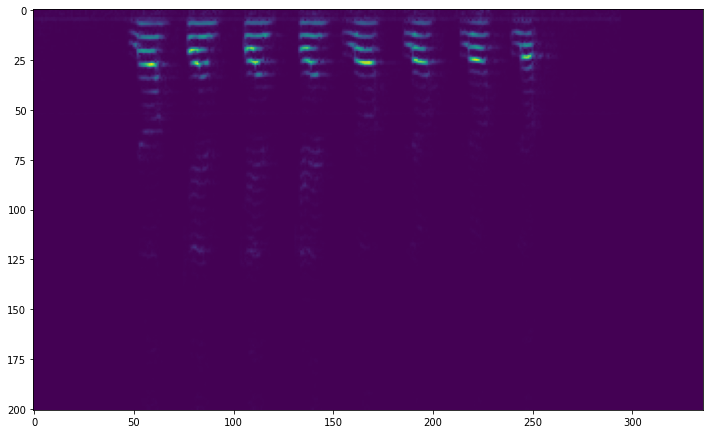

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

x, y = next(iter(data_loader))
print(type(x), x.shape)
print(type(y), y.shape)
plt.figure()

# visualize waveform
plt.plot(x[0,0])
plt.figure(figsize=(12,8))

# visualize torchaudio spectrogram
torchaudiospectro = torchaudio.transforms.Spectrogram(n_fft=400, win_length=400, hop_length=160)(x)
plt.imshow(np.log(torchaudiospectro[0,0]))
plt.figure(figsize=(12,8))

# create my spectrogram
from numpy.lib.stride_tricks import as_strided
WSIZE_SEC = 0.025
WSTRIDE_SEC = 0.01
FS = 16000
NFFT = 400
WSIZE = int(FS  * WSIZE_SEC) # TODO
WSTRIDE = int(FS * WSTRIDE_SEC) # TODO
WINDOW = np.hamming(WSIZE) # TODO


def myspectrogram(inp):
  s = inp
  # TODO
 
  movement = (len(s) - float(WSIZE)) // WSTRIDE+1 

  frames = as_strided(s, shape= (int(movement),WSIZE),strides=(s.strides[0]*WSTRIDE , s.strides[0])).copy()

  frames *= WINDOW

  s = np.abs(np.fft.rfft(frames)) 

  return s / np.sqrt((WINDOW ** 2).sum())

# visualize my spectrogram
myspectro = np.log10(1.0 + myspectrogram(x[0,0].numpy().astype(np.double))).transpose()
plt.imshow(myspectro)
plt.show()

## 2.2 Mel scale

**Exercise 2 (OPTIONAL, difficult):** implement a Mel scale, compare it to `torchaudio`'s. Compare (with plots and a file) your Mel spectrogram to `torchaudio`'s. Feel free to use Hertz to Mel: $2595 \log_{10}(1 + f/700)$, and remember that filterbanks are triangular, maximum at the center frequency and linear to 0 at the center frequency of the above and below filter.

(201, 80)


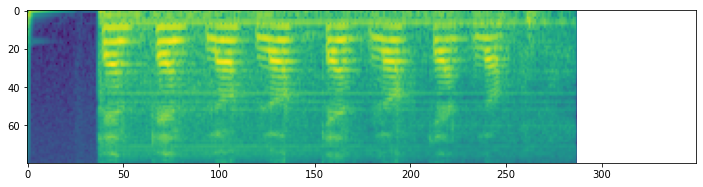

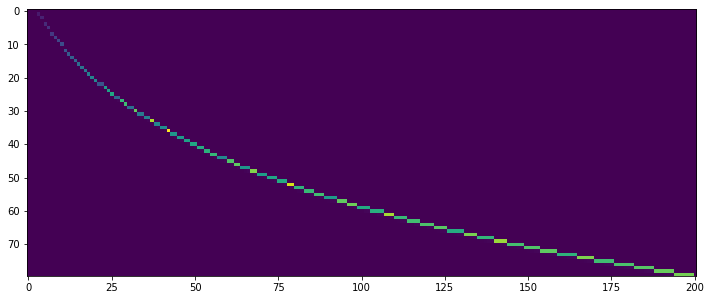

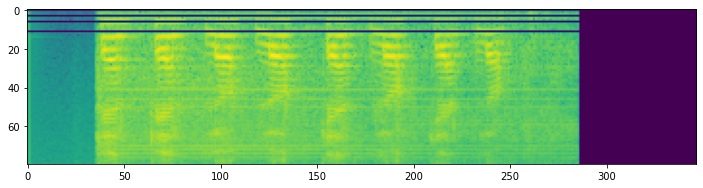

In [ ]:
import warnings
warnings.filterwarnings("ignore")
x, y = next(iter(data_loader))

NMELS = 80


# visualize torchaudio log Melspectrogram
plt.figure(figsize=(12,8))
torchaudiomelspectro = torchaudio.transforms.MelSpectrogram(n_fft=400, win_length=400, hop_length=160, n_mels=NMELS)(x)
plt.imshow(np.log(torchaudiomelspectro[0,0]))

# visualize my Mel scale
plt.figure(figsize=(12,8))
mymelscale = np.zeros((NFFT//2+1, NMELS), dtype=np.double)

def hertz_to_mel(freq):
  return 2595 * np.log10(1 + freq/700.0)

def mel_to_hertz(mel):
  return 700 * (10 ** (1.0 *mel / 2595) -1)

# TODO complete your Mel scale (you need to do something like mel_to_hertz(np.linspace(hertz_to_mel(100), hertz_to_mel(8000), TODO)))
nfilt = 80
lowfreq = 100
highfreq = 8000
samplerate = 16000

melpoints = np.linspace(hertz_to_mel(lowfreq),hertz_to_mel(highfreq),nfilt + 2)

fft_bin = (NFFT + 1) * mel_to_hertz(melpoints) // samplerate 

mymelscale = np.zeros((nfilt,int(np.floor(NFFT // 2 + 1))))

for j in range(0,nfilt):
  for i in range(int(fft_bin[j]),int(fft_bin[j + 1])):
    mymelscale[j , i] = (i - fft_bin[j]) / (fft_bin[j+ 1] -fft_bin[j])
  for i in range(int(fft_bin[j + 1]),int(fft_bin[j + 2])):
    mymelscale[j , i] = (fft_bin[j + 2] - 1) / (fft_bin[j + 2] - fft_bin[j + 1])

print(mymelscale.transpose().shape)
plt.imshow(mymelscale)
myspectro = myspectrogram(x[0,0].numpy().astype(np.double)).transpose()

# visualize my Melspectrogram PROBABLY QUITE FAR OFF (lots of pre/post processing gain/filters for torchaudio's)
plt.figure(figsize=(12,8))
mymelspectro = np.dot(myspectro.transpose(), mymelscale.transpose()).clip(1.0e-8, 1.0e8)
plt.imshow(np.log(mymelspectro.transpose()))

## 2.3 putting it together

**Exercise 3 (OPTIONAL):** redo the training loop from the first lab (1.5), with your log compressed Melspectrogram if you did 2.2, or with powerspectrum if you only did 2.1, as input features.

In [ ]:
# TODO (copy from your working 1.5 to get started)
import torch.nn as nn
import torch.nn.functional as F

class SimpleConvNet(nn.Module):
  def __init__(self, kernel_size=3, stride=1, padding=1, depth=5):  ### Those are not good hyperparameters
    super(SimpleConvNet, self).__init__()
    self.conv_featuers = nn.Sequential(nn.Conv1d(in_channels = 80, out_channels = 248, kernel_size = 3, padding = 1, stride = 1),
                                       nn.BatchNorm1d(248), nn.ReLU(), nn.MaxPool1d(3),
                                       nn.Conv1d(in_channels = 248, out_channels = 128, kernel_size = 3, padding = 1, stride = 1), 
                                       nn.BatchNorm1d(128), nn.ReLU(), nn.MaxPool1d(3),
                                       nn.Conv1d(in_channels = 128, out_channels = 64, kernel_size = 3, padding = 1, stride = 1),
                                       nn.BatchNorm1d(64), nn.ReLU(), nn.MaxPool1d(3))
       
    self.averge_pool = nn.AdaptiveAvgPool1d(1)
    self.linear = nn.Linear(64, 8)

  def forward(self, x):
    
    x = self.conv_featuers(x)
    x = self.averge_pool(x)
    x = x.view(x.size(0),-1)
    x = self.linear(x)
    return x 

model = SimpleConvNet()


import torch.optim as optim

N_EPOCHS = 100

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = SimpleConvNet().to(device) 

criterion = nn.MSELoss()  
optimizer = optim.AdamW(model.parameters(),lr = 0.001)  

running_loss = 0.0
i = 0
for epoch in range(N_EPOCHS):
  for x, y in data_loader:
    all_sample = []
    for j in range(x.shape[0]):
      xi = np.log(1.0 + myspectrogram(x[j,0].numpy())).T
      xi = np.dot(mymelscale,xi).clip(1.e-8, 1.e-8)
      xi = np.log(1 +xi.T)
      all_sample.append(torch.from_numpy(xi))
    
    x = torch.stack(all_sample)
    x = timemasking(freqmasking(x))
    x, y = x.to(device).float(), y.to(device)
    
    pred = model(x.permute(0, 2, 1))
    loss = criterion(pred,y.type_as(pred))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    i += 1
    running_loss += loss.item()
    if i % 20 == 0:
      print("loss: %.8f" % (running_loss / 20))
      running_loss = 0.0


loss: 0.36422146
loss: 0.25464087
loss: 0.24856245
loss: 0.24871552
loss: 0.24875537
loss: 0.24815488
loss: 0.24881967
loss: 0.24919518
loss: 0.24878334
loss: 0.24846358
loss: 0.24860918
loss: 0.24957361
loss: 0.24819878
loss: 0.24853965
loss: 0.24867466
loss: 0.24860073
loss: 0.24862769
loss: 0.24770305
loss: 0.24874975
loss: 0.24840976


## 2.4 wav-based acoustic model

**Exercice 4:** remove the log Mel filterbanks features in your training loop (section 1.5) and add one convolution (in 1.3) at the very beginnning of the model, that outputs **at the same striding and over the same windows as the Mel filterbanks feature do**. Visualize what you learned for this convolution at the end of training. Hint: you may need to train a bit longer or with a slightly different learning rate than you did in the past.

BONUS: SpecAugment is the same in time, but the frequency masking becomes a [band-stop filter](https://en.wikipedia.org/wiki/Band-stop_filter), you can implement it with scipy/numpy.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class SimpleConvNetWav(nn.Module):
  def __init__(self, kernel_size=3, stride=1, padding=1, depth=5):  ### Those are not good hyperparameters
    super(SimpleConvNetWav, self).__init__()
    self.kernel_size = kernel_size
    self.stride = stride 
    self.padding = padding 
    self.depth = depth
    self.conv_featuers = nn.Sequential(nn.Conv1d(in_channels = 1, out_channels = 80, kernel_size = 3, padding = 1, stride = 1),
                                       nn.BatchNorm1d(80), nn.ReLU(), nn.MaxPool1d(3),
                                       nn.Conv1d(in_channels = 80, out_channels = 248, kernel_size = 3, padding = 1, stride = 1),
                                       nn.BatchNorm1d(248), nn.ReLU(), nn.MaxPool1d(3),
                                       nn.Conv1d(in_channels = 248, out_channels = 128, kernel_size = 3, padding = 1, stride = 1), 
                                       nn.BatchNorm1d(128), nn.ReLU(), nn.MaxPool1d(3),
                                       nn.Conv1d(in_channels = 128, out_channels = 64, kernel_size = 3, padding = 1, stride = 1),
                                       nn.BatchNorm1d(64), 
                                       nn.ReLU(), 
                                       nn.MaxPool1d(3)
                                       )
       
    self.averge_pool = nn.AdaptiveAvgPool1d(1)
    self.linear = nn.Linear(64, 8)

  def forward(self, x):
    
    x = self.conv_featuers(x)
    x = self.averge_pool(x)
    x = x.view(x.size(0),-1)
    x = self.linear(x)
    return x 

N_EPOCHS = 100

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = SimpleConvNetWav().to(device)  # TODO change hyperparams of SimpleConvNetWav

criterion = nn.MSELoss()  # TODO
optimizer = optim.AdamW(model.parameters(),lr=0.001)  # TODO

running_loss = 0.0
i = 0    # TODO
    

for epoch in range(N_EPOCHS):
  for x, y in data_loader:
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    yhat = model(x)
    loss = criterion(yhat, y.float())
    loss.backward()
    optimizer.step()
    i += 1

    running_loss += loss.item()
    if i % 20 == 0:
      print("loss: %.8f" % (running_loss / 20))
      running_loss = 0.0

loss: 0.28888360
loss: 0.23410065
loss: 0.22440534
loss: 0.21767670
loss: 0.21250989
loss: 0.20459715
loss: 0.19960101
loss: 0.19414691
loss: 0.19007917
loss: 0.18390901
loss: 0.17058624
loss: 0.16486292
loss: 0.15816144
loss: 0.15582513
loss: 0.15105035
loss: 0.13962153
loss: 0.13045452
loss: 0.12342857
loss: 0.11572141
loss: 0.11814998


## 2.5 OPTIONAL: LibriSpeech 100h

If you are patient enough (the training will take many hours even with a small model) you can redo any of the previous training loops on 100h of read English speech, LibriSpeech train-clean-100. And now, you have a dev and test set! (So you can do proper machine learning!) If you do direct classification you could use words as targets, if you're using CTC, you can use letters. **Tip:** if you want to "debug by overfitting", _train_ on the dev (validation) set only.

In [ ]:
import os
from typing import Tuple

import torchaudio
from torch import Tensor
from torch.utils.data import Dataset
from torchaudio.datasets.utils import (
  download_url,
  extract_archive,
  walk_files,
)

URL = "train-clean-100"
FOLDER_IN_ARCHIVE = "LibriSpeech"
BASE_URL = "https://dl.fbaipublicfiles.com/librispeech_100h_mp3/"
_CHECKSUMS = {
  BASE_URL + "dev-clean.tar.gz":
  "076916a8f9c61951c5d2e6efaa8d2188232fcf860eec8c074e46edf4fac9623e",
  BASE_URL + "test-clean.tar.gz":
  "3c171e2f1e377e4993c2dbe6bff3f01cd324c0ed462f4de6c78737402a7dbedd",
  BASE_URL + "train-clean-100.tar.gz":
  "7bfbefc680d25ba3a82798ce32c287ea0e82932af1b1f864fae71fb52d2f41f0",
}


def load_librispeech_item(fileid: str, 
                          path: str, 
                          ext_audio: str, 
                          ext_txt: str) -> Tuple[Tensor, int, str, int, int, int]:
  speaker_id, chapter_id, utterance_id = fileid.split("-")

  file_text = speaker_id + "-" + chapter_id + ext_txt
  file_text = os.path.join(path, speaker_id, chapter_id, file_text)

  fileid_audio = speaker_id + "-" + chapter_id + "-" + utterance_id
  file_audio = fileid_audio + ext_audio
  file_audio = os.path.join(path, speaker_id, chapter_id, file_audio)

  # Load audio
  waveform, sample_rate = torchaudio.load(file_audio)

  # Load text
  with open(file_text) as ft:
    for line in ft:
      fileid_text, utterance = line.strip().split(" ", 1)
      if fileid_audio == fileid_text:
        break
    else:
      # Translation not found
      raise FileNotFoundError("Translation not found for " + fileid_audio)

  return (
    waveform,
    sample_rate,
    utterance,
    int(speaker_id),
    int(chapter_id),
    int(utterance_id),
  )


class LIBRISPEECH_100H_MP3(Dataset):
  """
  Create a Dataset for LibriSpeech. Each item is a tuple of the form:
  waveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id
  """

  _ext_txt = ".trans.txt"
  _ext_audio = ".mp3"

  def __init__(self,
         root: str,
         url: str = URL,
         folder_in_archive: str = FOLDER_IN_ARCHIVE,
         download: bool = False) -> None:

    if url in [
      "dev-clean",
      "test-clean",
      "train-clean-100",
    ]:

      ext_archive = ".tar.gz"
      base_url = BASE_URL

      url = os.path.join(base_url, url + ext_archive)

    basename = os.path.basename(url)
    archive = os.path.join(root, basename)

    basename = basename.split(".")[0]
    folder_in_archive = os.path.join(folder_in_archive, basename)

    self._path = os.path.join(root, folder_in_archive)

    if download:
      if not os.path.isdir(self._path):
        if not os.path.isfile(archive):
          checksum = _CHECKSUMS.get(url, None)
          download_url(url, root, hash_value=checksum)
        extract_archive(archive)

    walker = walk_files(
      self._path, suffix=self._ext_audio, prefix=False, remove_suffix=True
    )
    self._walker = list(walker)

  def __getitem__(self, n: int) -> Tuple[Tensor, int, str, int, int, int]:
    fileid = self._walker[n]
    return load_librispeech_item(fileid, self._path, self._ext_audio, self._ext_txt)

  def __len__(self) -> int:
    return len(self._walker)


Now you have access to a training set, but also a validation set ("dev" for development) to perform early stopping and hyperparams optimization on (you can look at it e.g. every epoch), and finally a test set (on which you should look at the performance only at the very end, after having completed training).

In [ ]:
libri_dev = LIBRISPEECH_100H_MP3(".", url="dev-clean", download=True)

In [ ]:
# just so you get an idea of the format 
print(next(iter(libri_dev)))
libri_dev = LIBRISPEECH_100H_MP3(".", url="dev-clean", download=True)

(tensor([[ 0.0000,  0.0000,  0.0000,  ..., -0.0002, -0.0002, -0.0001]]), 16000, 'CELERY AND NUT SALAD CUT ENOUGH CELERY FINE TO MEASURE TWO CUPS ADD ONE CUP OF FINELY SHREDDED OR SHAVED CABBAGE AND ONE AND ONE HALF CUPS OF WALNUT MEATS BROKEN IN SMALL PIECES BUT NOT CHOPPED', 652, 129742, 9)


In [ ]:
# bigger download, shouuld take 2-3 minutes on Colab
libri_train = LIBRISPEECH_100H_MP3(".", url="train-clean-100", download=True)
libri_test = LIBRISPEECH_100H_MP3(".", url="test-clean", download=True)

In [ ]:
# Only use this if your acoustic model outputting words directly
#lexicon = set()
#for utterance in libri_train:  # TODO use parallel Pool.map() and reduce the sets
#  lexicon.update(utterance[2].split())
#print("Lexicon's size: {}".format(len(lexicon)))

In [ ]:
# Use this is your acoustic model is outputting letters
tokens_list = list(" ABCDEFGHIJKLMNOPQRSTUVWXYZ")
tokens_set = set(tokens_list)
print(tokens_list)

[' ', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [ ]:
def collate_fn_libri(batch):
  #print(batch)
  tensors = [b[0].t() for b in batch if b]
  tensors_len = [len(t) for t in tensors]
  tensors = torch.nn.utils.rnn.pad_sequence(tensors, batch_first=True)
  tensors = tensors.transpose(1, -1)

  transcriptions = [list(b[2].replace("'", " ")) for b in batch if b]
  targets = [torch.tensor([tokens_list.index(e) for e in t]) for t in transcriptions]
  targets_len = [len(t) for t in targets]
  targets = torch.nn.utils.rnn.pad_sequence(targets, batch_first=True)

  return tensors, targets, torch.tensor(tensors_len), torch.tensor(targets_len)

train_set = torch.utils.data.DataLoader(libri_train, batch_size=2, shuffle=True,
                                        num_workers=4, collate_fn=collate_fn_libri)

In [ ]:
print(next(iter(train_set)))
train_set = torch.utils.data.DataLoader(libri_train, batch_size=16, shuffle=True,
                                        num_workers=2, collate_fn=collate_fn_libri)

(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0006, 0.0009, 0.0010]]]), tensor([[23,  1, 19,  0, 20,  8,  9, 19,  0, 23,  8,  1, 20,  0,  3,  1, 13,  5,
          0, 15,  6,  0, 16, 18,  1, 25,  9, 14,  7,  0, 19,  8,  5,  0, 20,  8,
         15, 21,  7,  8, 20,  0,  2,  9, 20, 20,  5, 18, 12, 25,  0, 19, 15, 13,
          5, 20,  8,  9, 14,  7,  0, 15, 18,  0, 15, 20,  8,  5, 18,  0,  9,  0,
          4, 15, 14,  0, 20,  0, 11, 14, 15, 23,  0, 23,  8,  1, 20,  0,  5, 24,
          1,  3, 20, 12, 25,  0, 18,  5, 20, 21, 18, 14,  5,  4,  0, 12,  5, 15,
         16, 15, 12,  4,  0, 15,  8,  0,  8,  5, 12,  5, 14,  0,  8,  5,  0,  2,
         18, 15, 11,  5,  0, 15, 21, 20,  0, 23,  9, 20,  8,  0,  1,  0,  3, 18,
         25,  0, 19, 20,  9,  6, 12,  5,  4,  0,  2, 25,  0, 20,  8,  5,  0,  3,
          1, 21, 20,  9, 15, 14,  0, 20,  8,  1, 20,  0,  8,  1,  4,  0,  7, 18,
         15, 23, 14,  0,  8,  1,  2,  9, 20, 21,  1, 1

# Part 3 End-to-end training

## 3.1 Train with CTC (using PyTorch's implementation)

**Exercise 1:** Train your `SimpleConvNet` with [`nn.CTCLoss`](https://pytorch.org/docs/master/generated/torch.nn.CTCLoss.html). Very hard to get it to converge (on Colab...), but the loss should be going down! That should be your criterion for success. If you're bored of YESNO, you can try LibriSpeech, the simplest is probably to train on the validation set (dev). I included some helper function for that with `collate_fn_libri` but feel free to roll your own.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

N_EPOCHS = 500
BATCH_SIZE = 32


def collate_fn_yesno(batch):
  tensors = [b[0].t() for b in batch if b]
  tensors_len = [len(t) for t in tensors]
  tensors = torch.nn.utils.rnn.pad_sequence(tensors, batch_first=True)
  tensors = tensors.transpose(1, -1)

  targets = torch.tensor([b[2] for b in batch if b]) + 1  # you can do it differently than the +1 if you want (it's to add room for the blank label at index 0)
  targets_len = [len(t) for t in targets]
  targets = torch.nn.utils.rnn.pad_sequence(targets, batch_first=True)

  return tensors, targets, torch.tensor(tensors_len), torch.tensor(targets_len)

yesno_dataset = YESNO(".", download=True)


### EXPERIMENTAL ###
MAX_X_LEN = 100  # limiting the length of the utterances, play with those
MAX_Y_LEN = 10   # limiting the length of the utterances, play with those
def collate_fn_libri(batch):
  tensors = [b[0][:MAX_X_LEN].t() for b in batch if b]
  tensors_len = [len(t) for t in tensors]
  tensors = torch.nn.utils.rnn.pad_sequence(tensors, batch_first=True)
  tensors = tensors.transpose(1, -1)

  transcriptions = [list(b[2].replace("'", " ")) for b in batch if b]
  targets = [torch.tensor([tokens_list.index(e) for e in t][:MAX_Y_LEN]) for t in transcriptions]
  targets_len = [len(t) for t in targets]
  targets = torch.nn.utils.rnn.pad_sequence(targets, batch_first=True)

  return tensors, targets, torch.tensor(tensors_len), torch.tensor(targets_len)

dev_set = torch.utils.data.DataLoader(libri_dev, batch_size=BATCH_SIZE, shuffle=True,
                                      num_workers=4, collate_fn=collate_fn_libri)  # yes, train on the dev set, to debug you model
### /EXPERIMENTAL ###


class SimpleConvNetCTC(nn.Module):
  def __init__(self, kernel_size=3, padding=1, depth=5):
    super(SimpleConvNetCTC, self).__init__()
    self.kernel_size = kernel_size 
    self.padding = padding 
    self.depth = depth
    self.conv_featuers = nn.Sequential(nn.Conv1d(in_channels = 80, out_channels = 124, kernel_size = 3, padding = 1, stride = 1),
                                       nn.BatchNorm1d(124), nn.ReLU(), nn.MaxPool1d(3),
                                       nn.Conv1d(in_channels = 124, out_channels = 248, kernel_size = 3, padding = 1, stride = 1),
                                       nn.BatchNorm1d(248), nn.ReLU(), nn.MaxPool1d(3),
                                       nn.Conv1d(in_channels = 248, out_channels = 128, kernel_size = 3, padding = 1, stride = 1), 
                                       nn.BatchNorm1d(128), nn.ReLU(), nn.MaxPool1d(3),
                                       nn.Conv1d(in_channels = 128, out_channels = 64, kernel_size = 3, padding = 1, stride = 1),
                                       nn.BatchNorm1d(64), 
                                       nn.ReLU(), 
                                       nn.MaxPool1d(3),
                                       nn.Conv1d(in_channels = 64, out_channels = 8, kernel_size = 3, padding = 1, stride = 1),
                                       nn.BatchNorm1d(8), 
                                       nn.ReLU(), 
                                       nn.MaxPool1d(3)
                                       )
       
    self.averge_pool = nn.AdaptiveAvgPool1d(32)
    

  def forward(self, x):
    
    x = self.conv_featuers(x)
    x = self.averge_pool(x)
    x = F.log_softmax(x,dim=1)
    
    
    return x 


data_loader = torch.utils.data.DataLoader(yesno_dataset, batch_size=BATCH_SIZE, shuffle=True,
                                          num_workers=2, collate_fn=collate_fn_yesno)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = SimpleConvNetCTC(kernel_size=5, padding=2, depth=7).to(device)
criterion = nn.CTCLoss(zero_infinity=True)
optimizer = optimizer = optim.AdamW(model.parameters(),lr=0.001)  ### TODO

running_loss = 0.0
i = 0
for epoch in range(N_EPOCHS):
  for x, y, x_len, y_len, in data_loader:  
    x_batch_len = x.shape[-1]
    x = torch.log(1. + melfbanks(x))
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    yhat = model(x.squeeze(1))
    yhat = yhat.permute(2,0,1)
    yhat_len = torch.tensor([int(yhat.shape[0]*x_len[i]/x_batch_len) for i in range(yhat.shape[1])]) # this is an approximation, should be good enough
    loss = criterion(yhat,y.float(),yhat_len,y_len)  ### TODO
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    i += 1

    running_loss += loss.item()
    if i % 100 == 0:
      print("loss: %.8f" % (running_loss / 20))
      running_loss = 0.0
      #print(yhat[0])
      #print(y[0])

loss: 11.33220646
loss: 8.57538622
loss: 7.59932889
loss: 6.94554834
loss: 6.56622138
loss: 6.25593493
loss: 6.00500148
loss: 5.82836910
loss: 5.61781516
loss: 5.39934678


## 3.2 Implementing CTC

**Exercise 2 (difficult):** Implement your own CTC loss `myCTC`, pass the assert here. Note that the predictions are in log probabilities, not in probabilities. https://distill.pub/2017/ctc/ may be helpful.

In [ ]:
#y = [1, 2] # simpler, for debug
#p = torch.rand(3, 3) # simpler for debug

y = [1, 2, 3]  # e.g. it's "cat"
p = torch.rand((4, 5))  # 5 classes because we add one other letter for fun + blank (ø, index 0)
p = F.log_softmax(p, dim=1)

criterion = nn.CTCLoss()
inp_len = torch.tensor([p.shape[0]]).unsqueeze(1)
tar_len = torch.tensor([len(y)]).unsqueeze(1)
p = p.unsqueeze(1)
print(p, p.shape)
y = torch.tensor(y).unsqueeze(0)
l = criterion(p, y, inp_len, tar_len)
print(l)

def myCTC(p, y, il, tl):
  """Returns the CTC loss of p (log probs) to y (targets) with blank label 0"""
  cache = [[None for _ in range(il.squeeze())] for _ in range(tl.squeeze())]  # cache[target][source]
  ### TODO complete this
  raise NotImplementedError
  return -1

assert torch.allclose(l, myCTC(p, y, inp_len, tar_len))

tensor([[[-1.6652, -2.0322, -1.3239, -1.8188, -1.3804]],

        [[-1.4874, -1.2300, -1.6990, -1.8506, -1.9539]],

        [[-1.6947, -1.0344, -1.9862, -1.6737, -1.9942]],

        [[-1.5114, -1.8781, -1.4144, -1.5876, -1.7202]]]) torch.Size([4, 1, 5])
tensor(1.6569)


NotImplementedError: ignored

## 3.3 Implementing Beam Search

**Exercise 3 (optional, difficult):** implement (vanilla) beam search, test it on the previous (`y` and `p`) example form 3.2. How can you deal with the blanks? The answer is in https://distill.pub/2017/ctc/